# __Cost of Education in Republican vs Democrat leaning US States__

### Group 15: Alice Le, Jitao Zhang, Lincoln Lee, Yitong Gong

### __2. Methods and Results__ 

In [1]:
# All needed libraries:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)

# General Graphs' setting:
options(repr.plot.width = 10, repr.plot.height = 6)

# Import online dataset
original_dataset <- read_csv("https://raw.githubusercontent.com/Jitao-Z/dataset/main/nces330_20.csv")
head(original_dataset)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Rows: 3548 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): State, Type, Length, Expense
dbl (2): Year, Value

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Year,State,Type,Length,Expense,Value
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
2013,Alabama,Private,4-year,Fees/Tuition,13983
2013,Alabama,Private,4-year,Room/Board,8503
2013,Alabama,Public In-State,2-year,Fees/Tuition,4048
2013,Alabama,Public In-State,4-year,Fees/Tuition,8073
2013,Alabama,Public In-State,4-year,Room/Board,8473
2013,Alabama,Public Out-of-State,2-year,Fees/Tuition,7736


__2.1 Cleaning the data__

The dataset also contains information regarding miscellaneous student costs such as books and living costs. Further, as we are using the 2020 presidential election as a gauge for the political leaning of each state, we want to rely on the data from 2020 only to avoid including data from when the political landscape may have been different.

Let's filter for just the data we're interested in: student tuition in 2020.

In [2]:
set.seed(2356)

# filters out all the irrelevant columns
tuition <- original_dataset |>
    filter(!is.na(Value),
           Expense == "Fees/Tuition",
           Year == 2020)

Now, we want to group the data by state to find the average cost of tuition in that state. Then, we want to append a column to the data correlating each state with their presidential election result (source below).

In [3]:
# calculates the mean tuition fee for each state in 2020
# mean_tuition_fee represents the average tuition fee for each state in 2020
tuition <- tuition |>
    group_by(State) |>
    summarize(mean_tuition_fees = mean(Value))


# adds the third column of political leaning
# note that we are using the party affiliation of each state in the 2020 presidential election 
# to represent their political leanings 
# demo stands for democrat; repub stands for republican
tuition <- tuition |>
    mutate(political_leaning = as.factor(ifelse(grepl("Arizona|California|Colorado|Connecticut|Delaware|Georgia|Hawaii
                                                |Illinois|Maine|Maryland|Massachusetts|Michigan|Minnesota
                                                |Nevada|New Hampshire|New Jersey|New Mexico|New York|Oregon
                                                |Pennsylvania|Rhode Island|Vermont|Virginia|Washington|Wisconsin", State), 
                                            "demo", "repub")))

head(tuition)
nrow(tuition |> filter(political_leaning == "demo"))
nrow(tuition |> filter(political_leaning == "repub"))

State,mean_tuition_fees,political_leaning
<chr>,<dbl>,<fct>
Alabama,13628.80,repub
Alaska,18248.67,repub
Arizona,12235.40,demo
Arkansas,12422.00,repub
California,17368.40,demo
Colorado,14833.20,demo


[1] 23

[1] 28

__2.2 Visualization of the initial data__

Let's use two boxplots side-by-side to get a general idea of the average tuition fees of schools in democrat and republican-leaning states in 2020.

Note that even though the boxplot **will not** reflect the true population parameters, it could still give us some insights into what our dataset looks like and facilitate some first guesses in the difference of mean tuition fees between democrat and republican states.

##### Figure 1: Boxplots for tuition fees of democrat and republican states in 2020

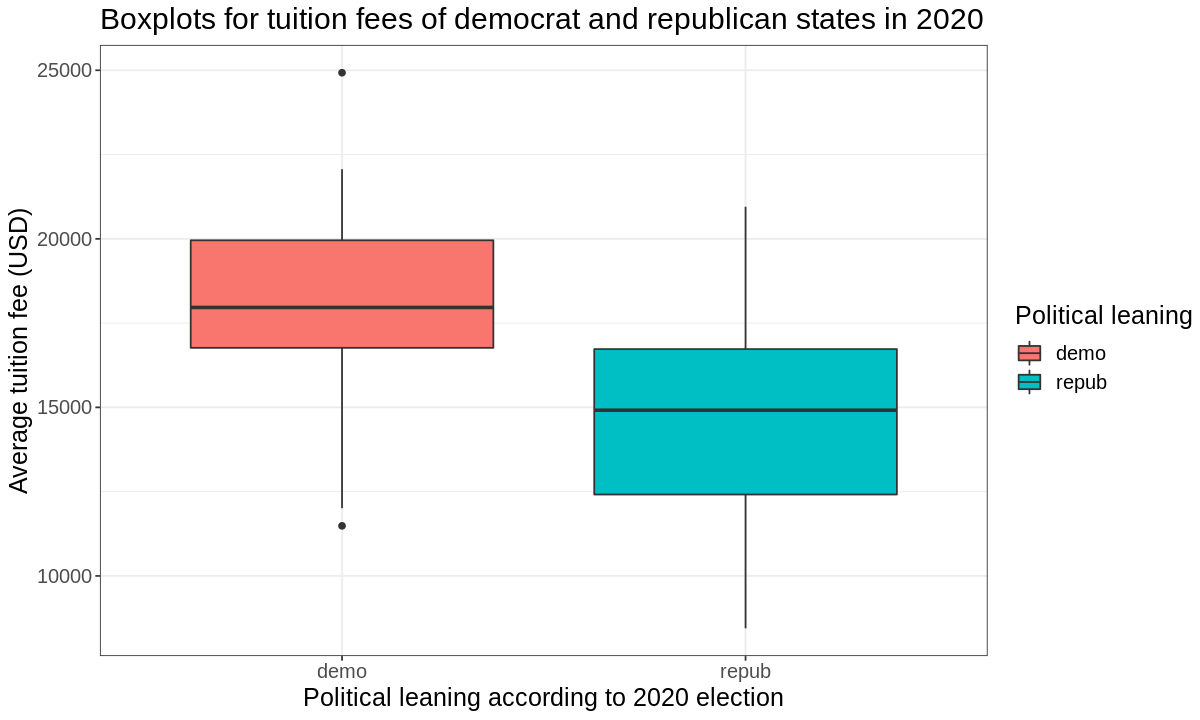

In [4]:
tuition_boxplots <- tuition |>
    ggplot(mapping = aes(x = political_leaning, y = mean_tuition_fees, fill = political_leaning)) +
    geom_boxplot() +
    ggtitle("Boxplots for tuition fees of democrat and republican states in 2020") +
    labs(x = "Political leaning according to 2020 election", y = "Average tuition fee (USD)", fill = "Political leaning") +
    theme_bw() +
    theme(text = element_text(size = 15))

tuition_boxplots

__2.3 Computation of estimate of the parameter__

Let's now take a closer look at the **difference** of these two means, starting with some variable definitions.

- $\mu_1$: population mean of tuition fees of democrat states in 2020
- $\mu_2$: population mean of tuition fees of republican states in 2020

- $\bar{x_1}$: sample mean of tuition fees of democrat states in 2020
- $\bar{x_2}$: sample mean of tuition fees of republican states in 2020

The difference of the two sample means, $\bar{x_1} - \bar{x_2}$, is used as our estimate to approximate $\mu_1 - \mu_2$, our parameter of interest.

##### Table 1: Difference between two sample means

In [5]:
summary <- tuition |>
    group_by(political_leaning) |>
    summarize(mean = mean(mean_tuition_fees))

# diff represents demo - repub
estimates <- data.frame(x1_bar = summary$mean[1],
                        x2_bar = summary$mean[2]) |>
    mutate(diff = x1_bar - x2_bar)

estimates

x1_bar,x2_bar,diff
<dbl>,<dbl>,<dbl>
17996.75,14564.99,3431.759


Our initial rough guess says the difference between the two samples means is **3431.759 USD**, suggesting that it is that much cheaper to attend school in a Republican-leaning state (though again, we will need to conduct a more thorough analysis for a concrete estimate)

<font color=red>So far, this is what we achieved in our proposal. Now, we are going to use both hypothesis test and confidence interval to further verify or repudiate our initial guess.</font>

__2.4 Hypothesis testing and Confidence interval__

Before we get started, let's first review our parameters, statistics, and hypotheses.

- $\mu_1$: population mean of tuition fees of democrat states in 2020
- $\mu_2$: population mean of tuition fees of republican states in 2020

- $\bar{x_1}$: sample mean of tuition fees of democrat states in 2020
- $\bar{x_2}$: sample mean of tuition fees of republican states in 2020

- <mark>$H_0: \mu_1 - \mu_2 = 0$<mark>
- <mark>$H_1: \mu_1 - \mu_2 > 0$<mark>

Since we don't know our population standard deviations, we will use sample standard deviations to approximate them to conduct a __2-sample t-test__ in the following process. After that, we will do another bootstrapping to compare the results obtained from these two methods.

Moreover, we will fix our __significance level__ $\alpha$ to be $5\%$ (obtain the 95% confidence interval).

__2.4.1 Theory-based hypothesis test__

In [6]:
head(tuition)

State,mean_tuition_fees,political_leaning
<chr>,<dbl>,<fct>
Alabama,13628.80,repub
Alaska,18248.67,repub
Arizona,12235.40,demo
Arkansas,12422.00,repub
California,17368.40,demo
Colorado,14833.20,demo


To start with, we will obtain all the variables we need to know to calculate our test statistic.

##### Table 2: Summary of all variables required to calculate the test statistic

In [7]:
tuition_summary_table <- tuition |>
    group_by(political_leaning) |>
    summarize(sample_mean = mean(mean_tuition_fees),
              sample_var = var(mean_tuition_fees),
              n = n())
tuition_summary_table

political_leaning,sample_mean,sample_var,n
<fct>,<dbl>,<dbl>,<int>
demo,17996.75,11465888,23
repub,14564.99,9532268,28


Based on the information we obtained from the above table, we can calculate the test statistic using:

$$
T = \frac{\bar{x}_{\text{Democrat}} - \bar{x}_{\text{Republican}}}{\sqrt{\frac{s^2_{\text{Democrat}}}{n_1}+\frac{s^2_{\text{Republican}}}{n_2}}}
$$

In [8]:
test_statistic <- (tuition_summary_table$sample_mean[1] - tuition_summary_table$sample_mean[2]) / 
                   sqrt(tuition_summary_table$sample_var[1]/tuition_summary_table$n[1] + tuition_summary_table$sample_var[2]/tuition_summary_table$n[2])
test_statistic

[1] 3.746687

Next, we can obtain the p-value for this hypothesis test under the consumption that $H_0$ is true

In [26]:
# p-value
p_value <- 1 - pt(test_statistic, 22)
p_value

[1] 0.0005582374

__Since our p-value is much smaller than our stated significance level (0.00025 < 0.05), we will <mark>Reject our null hypothesis<mark>.__
This also obeys our initial guess: it is much more expensive to attend school in a Democrat-leaning state.

#### Besides the p-value, we can also use the Theory-based method to construct a 95% confidence interval

##### Table 3: Confidence interval calculated by the Theory-based method

In [18]:
critical_value <- qt(0.5+0.95/2, df)
standard_error <- sqrt(tuition_summary_table$sample_var[1]/tuition_summary_table$n[1] + tuition_summary_table$sample_var[2]/tuition_summary_table$n[2])

confidence_interval <- tibble(
    lower_ci = (tuition_summary_table$sample_mean[1] - tuition_summary_table$sample_mean[2]) - critical_value * standard_error,
    upper_ci = (tuition_summary_table$sample_mean[1] - tuition_summary_table$sample_mean[2]) + critical_value * standard_error)
confidence_interval

lower_ci,upper_ci
<dbl>,<dbl>
1587.121,5276.397


By calculating this confidence interval, we are 95% confident that the actual $\mu_1 - \mu_2$ will be between 1587.121 and 30717.1

#### Finally, we can use the function `t.test` in R to reconfirm all the above results.

##### Table 4: Summary by applying t.test

In [17]:
summary <- tidy(
    t.test(x = tuition |> filter(political_leaning == "demo") |> select(mean_tuition_fees),
           y = tuition |> filter(political_leaning == "repub") |> select(mean_tuition_fees),
           alternative = "two.sided",
           conf.level = 0.95))
summary

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
3431.759,17996.75,14564.99,3.746687,0.000506493,45.15059,1587.121,5276.397,Welch Two Sample t-test,two.sided


__2.4.2 Bootstrapping hypothesis test__

In [12]:
head(tuition)

State,mean_tuition_fees,political_leaning
<chr>,<dbl>,<fct>
Alabama,13628.80,repub
Alaska,18248.67,repub
Arizona,12235.40,demo
Arkansas,12422.00,repub
California,17368.40,demo
Colorado,14833.20,demo


In [13]:
set.seed(1)
diff_in_means <- tuition |>
    specify(mean_tuition_fees ~ political_leaning) %>%
    hypothesize(null = "independence") %>% 
    generate(reps = 2000, type = "permute") %>% 
    calculate(stat= "diff in means", order = c("demo", "repub"))
head(diff_in_means)

replicate,stat
<int>,<dbl>
1,429.02195
2,465.29081
3,195.18747
4,45.66667
5,662.42746
6,1917.77187


In [14]:
bootstrap_pvalue <- diff_in_means |>
    get_p_value(obs_stat = estimates$diff, direction = "right")

bootstrap_pvalue

p_value
<dbl>
5e-04


In [15]:
diff_in_means_ci <- tuition |>
    specify(mean_tuition_fees ~ political_leaning) %>% 
    generate(reps = 2000, type = "bootstrap") %>% 
    calculate(stat = "diff in means", order = c("demo", "repub")) |>
    get_confidence_interval(level = 0.95, type = "percentile")
diff_in_means_ci


lower_ci,upper_ci
<dbl>,<dbl>
1635.661,5339.357


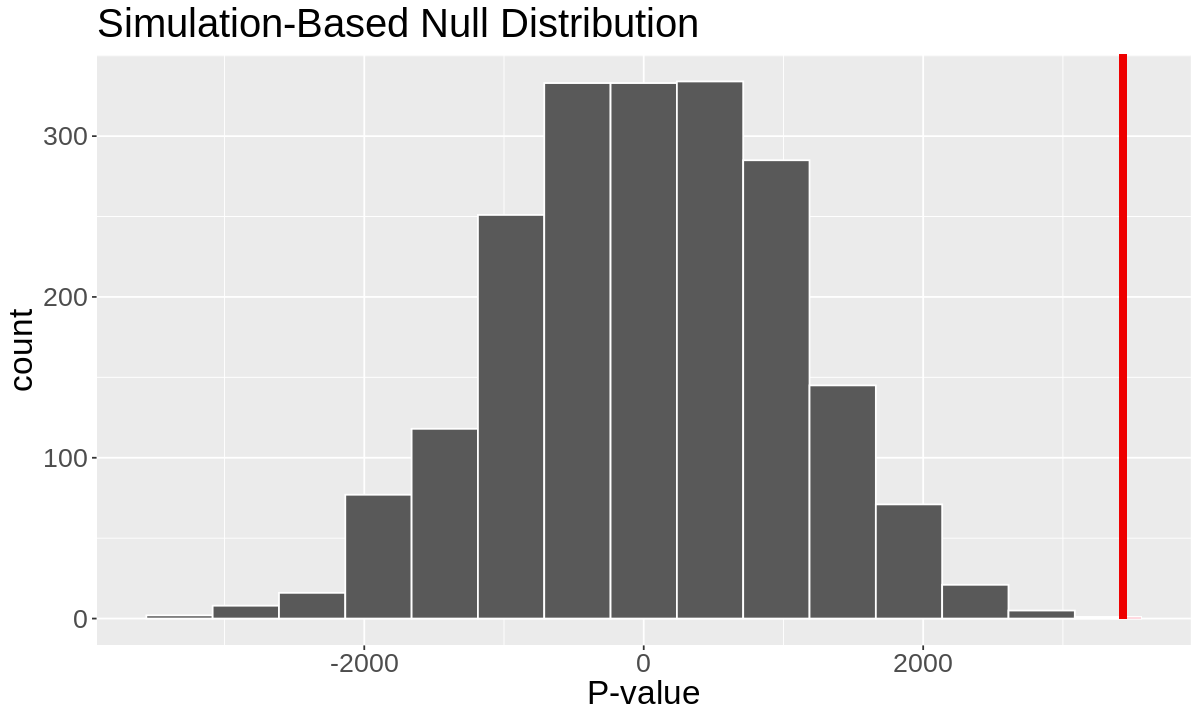

In [16]:
null_model_vis_infer <- diff_in_means |>
   visualize() + 
   shade_p_value(obs_stat = estimates$diff, direction = "right") +
   xlab("P-value") + 
   theme(text = element_text(size=20))
null_model_vis_infer

In [ ]:
histogram <- tuition |>
    